In [22]:
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import re
import warnings
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
def get_dataset():
    featureset_path = "/content/train_features.csv"
    targetset_path = "/content/train_targets.csv"

    df = pd.read_csv(featureset_path)
    target = pd.read_csv(targetset_path)

    print("Features: ",df.columns,"\n")
    print("Target Columns: ",target.columns,"\n")

    column_to_drop = ["lobby_type","chat_len","game_mode"] # "match_id_hash","objectives_len"

    filter = "(game_mode == 2 or game_mode == 22) and game_time > 0" # 2 standard ranked or 22 captain mode

    df = df.query(filter)

    df = df.drop(labels=column_to_drop,axis=1)

    tf_toreplace = ["r1_teamfight_participation", "r2_teamfight_participation","r3_teamfight_participation", "r4_teamfight_participation",
                    "r5_teamfight_participation","d1_teamfight_participation","d2_teamfight_participation","d3_teamfight_participation",
                    "d4_teamfight_participation",  "d5_teamfight_participation"]

    for label in tf_toreplace:
        df.loc[df[label] > 1.0, label] = 1

    #a = df.loc[df["match_id_hash"] == "a400b8f29dece5f4d266f49f1ae2e98a"] #hash where nothing change = a400b8f29dece5f4d266f49f1ae2e98a ; hash where something change = 8e0ad8cbcf5a87c451e5e1e07596c443
    #print(a[tf_toreplace])

    print("Filtering Df: ", filter, "\n")

    print("Dropped: ",column_to_drop,"\n")

    print("Dataframe Shape: ",df.shape,"\n")

    return df,target


def get_hero_id_labels(df: pd.DataFrame) -> list[str]:
    hero_id_labels = [s for s in df.columns if s.endswith('_hero_id')]
    print("Hero Id Labels:",hero_id_labels,"\n")
    return hero_id_labels

def get_single_hero_labels(df: pd.DataFrame) -> list[str]:
    single_hero_labels = [s for s in df.columns if re.match(r"^(d|r)\d",s)]
    print("Single Hero Labels:",single_hero_labels,"\n")
    return single_hero_labels

def drop_heros_labels(df:pd.DataFrame) -> pd.DataFrame:
    hero_id_labels = get_hero_id_labels(df)
    if (len(hero_id_labels) == 0):
        for label in df.columns:
            if re.match(r"^(d|r)_\d*$",label):  #regex: r_1 d_2 ecc...
                df = df.drop(label,axis=1)
            elif re.match(r"^(d|r)\d_hero_id_\d*$",label):      #regex: r1_hero_id_12 d3_hero_id_101 ecc..
                df = df.drop(label,axis=1)
    else:
        df = df.drop(labels=hero_id_labels,axis=1)

    print("Dropped Dataframe Shape:",df.shape)

    return df


def playerstats_playerheros_transform(df: pd.DataFrame, target: pd.DataFrame):

    features_toonehot = ["r1_hero_id","r2_hero_id","r3_hero_id","r4_hero_id","r5_hero_id","d1_hero_id","d2_hero_id","d3_hero_id","d4_hero_id","d5_hero_id"]
    df = pd.get_dummies(df,columns=features_toonehot)

    target = target.loc[df.index]
    print(target.shape)
    df = df.drop('match_id_hash',axis=1)

    return df,target

def playerstats_teamheros_transform(df: pd.DataFrame, target: pd.DataFrame):

    hero_id_labels = get_hero_id_labels(df)

    hero_id_set = {i: set() for i in range(len(hero_id_labels))}

    hero_id_set_tot = set()

    for n,label in enumerate(hero_id_labels):
        for id in df[label]:
            hero_id_set[n].add(id)

    for i in range(len(hero_id_labels)):
        #print(f"{i}. {len(hero_id_set[i])}")
        hero_id_set_tot = hero_id_set_tot.union(hero_id_set[i])

    print("Numbers of Heros: ",len(hero_id_set_tot),"\n")

    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

    for hero_id in hero_id_set_tot:
        df[f"r_{hero_id}"] = (
            (df["r1_hero_id"] == hero_id) |
            (df["r2_hero_id"] == hero_id) |
            (df["r3_hero_id"] == hero_id) |
            (df["r4_hero_id"] == hero_id) |
            (df["r5_hero_id"] == hero_id)
        ).astype(int)
        df[f"d_{hero_id}"] = (
            (df["d1_hero_id"] == hero_id) |
            (df["d2_hero_id"] == hero_id) |
            (df["d3_hero_id"] == hero_id) |
            (df["d4_hero_id"] == hero_id) |
            (df["d5_hero_id"] == hero_id)
        ).astype(int)

    warnings.simplefilter(action="default",category=pd.errors.PerformanceWarning)

    df = df.drop(labels=hero_id_labels,axis=1) #removed ri_hero_id and di_hero_id

    print("Dataframe Shape:",df.shape,"\n")

    #print(df.iloc[0]["match_id_hash"])
    #print(df.iloc[0][df.iloc[0] == 1][-11:])

    print("NaN Count: ",pd.isna(df).sum().sum(),"\n")

    df = df.copy()

    """ i = 0
    for v in df['d_32']:
        if v == 1:
            i += 1
    print(f"Total: {i}") """

    target = target.loc[df.index]
    print(target.shape)
    df = df.drop('match_id_hash',axis=1)

    return df,target

def teamstats_teamheros_transform(df: pd.DataFrame, target: pd.DataFrame):

    #region team heroes grouping

    hero_id_labels = get_hero_id_labels(df)

    hero_id_set = {i: set() for i in range(len(hero_id_labels))}

    hero_id_set_tot = set()

    for n,label in enumerate(hero_id_labels):
        for id in df[label]:
            hero_id_set[n].add(id)

    for i in range(len(hero_id_labels)):
        #print(f"{i}. {len(hero_id_set[i])}")
        hero_id_set_tot = hero_id_set_tot.union(hero_id_set[i])

    print("Numbers of Heros: ",len(hero_id_set_tot),"\n")

    # r_100 = r1_hero_id == 100 or r2_hero_id == 100 or r3_hero_id == 100 ...
    for hero_id in hero_id_set_tot:
        df[f"r_{hero_id}"] = (
            (df["r1_hero_id"] == hero_id) |
            (df["r2_hero_id"] == hero_id) |
            (df["r3_hero_id"] == hero_id) |
            (df["r4_hero_id"] == hero_id) |
            (df["r5_hero_id"] == hero_id)
        ).astype(int)
        df[f"d_{hero_id}"] = (
            (df["d1_hero_id"] == hero_id) |
            (df["d2_hero_id"] == hero_id) |
            (df["d3_hero_id"] == hero_id) |
            (df["d4_hero_id"] == hero_id) |
            (df["d5_hero_id"] == hero_id)
        ).astype(int)

    #endregion

    df = df.drop(labels=hero_id_labels,axis=1) #removed ri_hero_id and di_hero_id

    print("Dataframe Shape:",df.shape,"\n")

    #print(df.iloc[0]["match_id_hash"])
    #print(df.iloc[0][df.iloc[0] == 1][-11:])

    print("NaN Count: ",pd.isna(df).sum().sum(),"\n")

    df = df.copy()

    """ i = 0
    for v in df['d_32']:
        if v == 1:
            i += 1
    print(f"Total: {i}") """

    #region team stats grouping
    single_hero_labels = get_single_hero_labels(df)
    single_hero_labels2 = single_hero_labels.copy()
    for label in single_hero_labels:
        if re.match(r".*(_x|_y)$",label):
            single_hero_labels2.remove(label)
            continue
        new_label = label[0]+label[2:]              #r1_gold -> r_gold
        if not (new_label in df.columns):
            df[new_label] = df[label]
        else:
            df[new_label] += df[label]
    single_hero_labels = single_hero_labels2.copy()
    df = df.drop(labels=single_hero_labels,axis=1).copy()
    print("New Dataframe Colums:",df.columns,"\n")
    print("New Dataframe Shape:",df.shape,"\n")

    #print(df.query("d_firstblood_claimed == 0 and r_firstblood_claimed == 0").shape)

    #endregion

    target = target.loc[df.index]
    print(target.shape)
    df = df.drop('match_id_hash',axis=1)

    return df,target


In [23]:
import pandas as pd
import numpy as np

In [24]:
df, target = get_dataset()
df, target = teamstats_teamheros_transform(df,target)

Features:  Index(['match_id_hash', 'game_time', 'game_mode', 'lobby_type',
       'objectives_len', 'chat_len', 'r1_hero_id', 'r1_kills', 'r1_deaths',
       'r1_assists',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=246) 

Target Columns:  Index(['match_id_hash', 'game_time', 'radiant_win', 'duration',
       'time_remaining', 'next_roshan_team'],
      dtype='object') 

Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode'] 

Dataframe Shape:  (32153, 243) 

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 



<ipython-input-22-c21d0c003469>:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"d_{hero_id}"] = (
<ipython-input-22-c21d0c003469>:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"r_{hero_id}"] = (
<ipython-input-22-c21d0c003469>:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"d

Dataframe Shape: (32153, 463) 

NaN Count:  0 

Single Hero Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r3_lh', 'r3_xp', 'r3_health', 'r3_max_health', 'r3_max_mana', 'r3_level', 'r3_x', 'r3_y', 'r3_stuns', 'r3_creeps_stacked', 'r3_camps_stacked', 'r3_rune_pic

In [25]:
win = target["radiant_win"].astype(int)
df = drop_heros_labels(df)

Hero Id Labels: [] 

Dropped Dataframe Shape: (32153, 64)


In [26]:
from sklearn.model_selection import train_test_split

np.random.seed(seed=10)

X_train,X_test,Y_train,Y_test = train_test_split(df,win,test_size=0.2)

In [27]:
np.random.seed(seed=10)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params = {
    "n_estimators": [100,200,250],
    "learning_rate": [1,1.5,2]
}

feature_selector = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=params,cv=StratifiedKFold(n_splits=5,shuffle=True))

feature_selector.fit(X_train,Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1, 1.5, 2],
                         'n_estimators': [200, 250]})

In [28]:
print(feature_selector.best_params_)
feature_selector = AdaBoostClassifier(**feature_selector.best_params_)
feature_selector.fit(X_train,Y_train)

{'learning_rate': 1.5, 'n_estimators': 200}


AdaBoostClassifier(learning_rate=1.5, n_estimators=200)

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score

Y_pred = feature_selector.predict(X_test)

acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)

print("Accouracy ",acc)
print("Auc",auc)

feature_importance = {
    name: value
    for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
}

feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
feature_names = list(feature_importance.keys())
print("Most Important:\n", feature_names[:10])
print("Least Important:\n", feature_names[-10:])

Accouracy  0.7076659928471466
Auc 0.7062435990952161
Most Important:
 ['r_towers_killed', 'd_kills', 'r_kills', 'd_towers_killed', 'r_health', 'd_lh', 'd_gold', 'd_health', 'r4_y', 'r_lh']
Least Important:
 ['r_firstblood_claimed', 'r_camps_stacked', 'r_creeps_stacked', 'r_level', 'r_xp', 'd4_y', 'd4_x', 'r3_x', 'objectives_len', 'game_time']


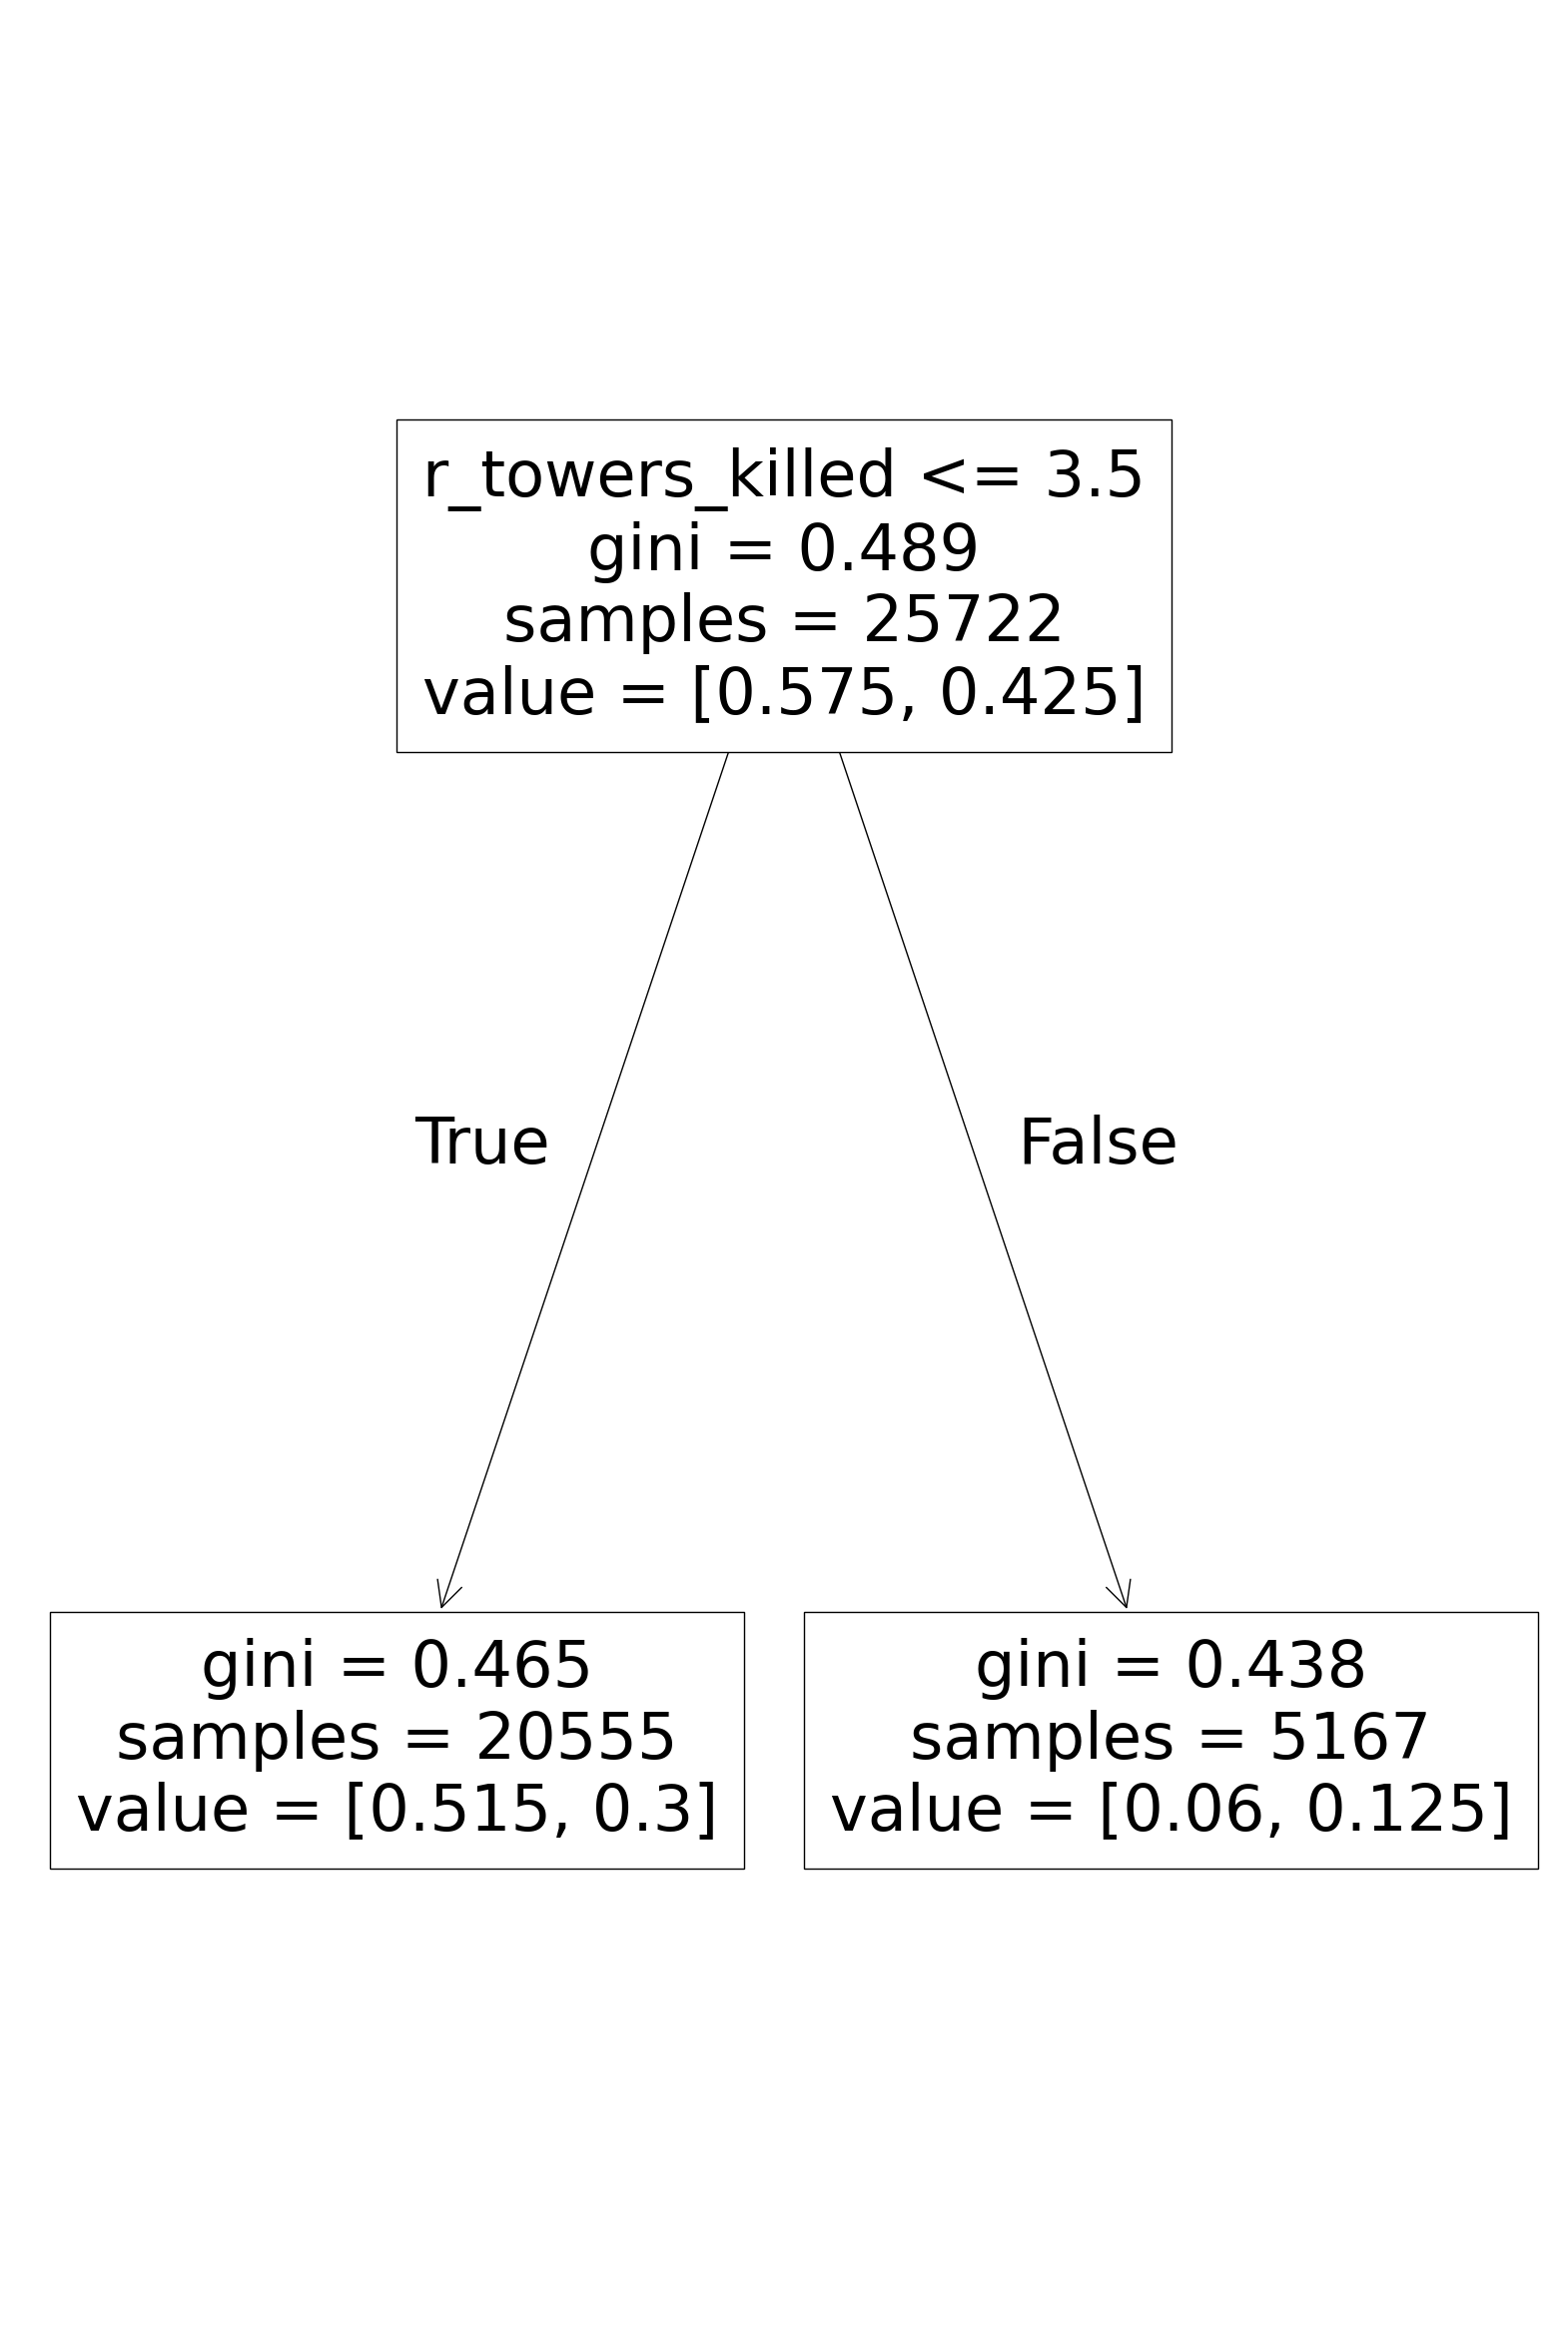

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = feature_selector.estimators_[1]

plt.figure(figsize=(20,30))
plot_tree(tree,max_depth=2,feature_names=df.columns)
plt.show()

In [ ]:
n_components = np.arange(10,df.shape[1],5)
gammas = np.linspace(0,2,5)

acc_dict = {}
roc_dict = {}

for n in n_components:
    for gamma in gammas:
        kpca = KernelPCA(n_components=n, kernel='rbf',gamma=gamma)
        X_train_kpca = kpca.fit_transform(X_train)
        feature_selector.fit(X_train_kpca,Y_train)
        Y_pred = feature_selector.predict(kpca.transform(X_test))
        roc_dict[n][gamma] = roc_auc_score(Y_test,Y_pred)
        acc_dict[n][gamma] = accuracy_score(Y_test,Y_pred)
        print(f"n {n}, gamma {gamma}: AUC - {roc_dict[n][gamma]}, Acc - {acc_dict[n][gamma]}")

In [ ]:
print(roc_dict)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = drop_heros_labels(X_train)
X_test = drop_heros_labels(X_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
n = 50
gamma = 0.5
kpca = KernelPCA(n_components=n, kernel='rbf',gamma=gamma)
X_train_kpca = kpca.fit_transform(X_train)
feature_selector.fit(X_train_kpca,Y_train)
Y_pred = feature_selector.predict(kpca.transform(X_test))
roc_dict[n][gamma] = roc_auc_score(Y_test,Y_pred)
acc_dict[n][gamma] = accuracy_score(Y_test,Y_pred)

Hero Id Labels: [] 

Dropped Dataframe Shape: (25722, 64)
Hero Id Labels: [] 

Dropped Dataframe Shape: (6431, 64)
